<a href="https://colab.research.google.com/github/shreeya-la/audio-ml/blob/main/vggish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Import

In [ ]:
!pip install tf_keras

In [ ]:
import tensorflow as tf
import tf_keras as tfk
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import librosa

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
!pip install soundfile
!pip install librosa

# VGGish

In [ ]:
# Load the model
vgg_model = hub.load('https://www.kaggle.com/models/google/vggish/TensorFlow2/vggish/1')

In [ ]:
# Input: three seconds of silence as mono 16 kHz waveform samples
waveform = np.zeros(3 * 16000, dtype=np.float32)
waveform.shape

(48000,)

In [ ]:
# Run the model, check the output
embeddings = vgg_model(waveform)
embeddings.shape.assert_is_compatible_with([None, 128])

In [ ]:
embeddings.shape

TensorShape([3, 128])

In [ ]:
def preprocess_wav(filename, target_sr=16000):
    # Load the .wav file using librosa
    audio, sampling_rate = librosa.load(filename, sr=None)

    # Resample to target sample rate (16kHz)
    audio = librosa.resample(audio, orig_sr=sampling_rate, target_sr=target_sr)

    # If audio has more than 1 channel, convert to mono
    if len(audio.shape) > 1:
        audio = librosa.to_mono(audio)

    # Convert to float32 TensorFlow tensor
    audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)

    return audio_tensor

# Download ESC50

In [ ]:
!test ! -f "master.zip" && wget "https://github.com/karoldvl/ESC-50/archive/master.zip"

--2024-09-25 18:24:47--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/karolpiczak/ESC-50/archive/master.zip [following]
--2024-09-25 18:24:48--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2024-09-25 18:24:48--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [     

In [ ]:
!unzip -qq master.zip

In [ ]:
%cd ESC-50-master

/content/ESC-50-master


In [ ]:
# create a dataframe
esc50 = pd.read_csv('meta/esc50.csv')
esc50.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [ ]:
# the 10 classes that are in the animals category
animals = ['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow']

esc50_animals = esc50[esc50['category'].isin(animals)]

# display the filtered dataset; should have 40*10 = 400 rows
print(esc50_animals)

              filename  fold  target category  esc10  src_file take
0     1-100032-A-0.wav     1       0      dog   True    100032    A
8     1-103298-A-9.wav     1       9     crow  False    103298    A
14    1-110389-A-0.wav     1       0      dog   True    110389    A
29    1-121951-A-8.wav     1       8    sheep  False    121951    A
45     1-15689-A-4.wav     1       4     frog  False     15689    A
...                ...   ...     ...      ...    ...       ...  ...
1983  5-261325-A-9.wav     5       9     crow  False    261325    A
1994  5-263831-A-6.wav     5       6      hen  False    263831    A
1995  5-263831-B-6.wav     5       6      hen  False    263831    B
1998   5-61635-A-8.wav     5       8    sheep  False     61635    A
1999    5-9032-A-0.wav     5       0      dog   True      9032    A

[400 rows x 7 columns]


# Sample of ESC50 with VGGish

In [ ]:
# get a sample .wav file
sample_file = esc50_animals.iloc[0]['filename']
esc_single_waveform = preprocess_wav('audio/' + sample_file)

# 5 seconds so shape should be (80000,)
esc_single_waveform.shape

TensorShape([80000])

In [ ]:
embeddings = vgg_model(esc_single_waveform)
embeddings.shape.assert_is_compatible_with([None, 128])

In [ ]:
# should be [5,128]
embeddings.shape

TensorShape([5, 128])

# Test ESC50 with VGGish

In [ ]:
# collect the 400 embedding outputs
embeddings_list = []
# and keep track of labels for training/testing
labels_list = []

for index, row in esc50_animals.iterrows():
    filename = row['filename']
    label = row['category']

    # preprocess each .wav file
    esc_waveform = preprocess_wav('audio/' + filename)

    # run VGGish and get the embeddings
    embeddings = vgg_model(esc_waveform)

    embeddings_list.append(embeddings)
    labels_list.append(label)

In [ ]:
# should be 400
print(len(embeddings_list))
# should be 400
print(len(labels_list))
# should be (5,128)
print(embeddings_list[0].shape)
# should be dog
print(labels_list[0])

400
400
(5, 128)
dog


# Full Classification

In [ ]:
# convert to numpy arrays
X = np.array(embeddings_list)
y = np.array(labels_list)

In [ ]:
# encode labels (one-hot)
lb = LabelBinarizer()
y_encoded = lb.fit_transform(y)

In [ ]:
# split training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# 10 animal classes
num_classes = len(animals)

# classification model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=[5, 128]),
    # LSTM layer to handle the sequence input
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9882 - loss: 0.0315 - val_accuracy: 0.8281 - val_loss: 0.8981
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9981 - loss: 0.0113 - val_accuracy: 0.7969 - val_loss: 0.9086
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0125 - val_accuracy: 0.7969 - val_loss: 0.9578
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9901 - loss: 0.0184 - val_accuracy: 0.8281 - val_loss: 0.9027
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0095 - val_accuracy: 0.7812 - val_loss: 0.8956
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.7969 - val_loss: 0.8903
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.8125 - val_loss: 0.9223
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.8125 - val_loss: 0.9541


In [ ]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.4f}')

# 20 epochs: 0.8250
# 30 epochs: 0.8750
# 40 epochs: 0.8750

# 30 epochs: 0.9125, 0.8625, 0.8750

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8570 - loss: 0.5189 
Test accuracy: 0.8625


In [ ]:
# get predicitions for X_test
y_pred_probs = model.predict(X_test)

# convert probabilities to labels
y_pred = np.argmax(y_pred_probs, axis=1)

# convert one-hot encoded y_test to class labels
y_true = np.argmax(y_test, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


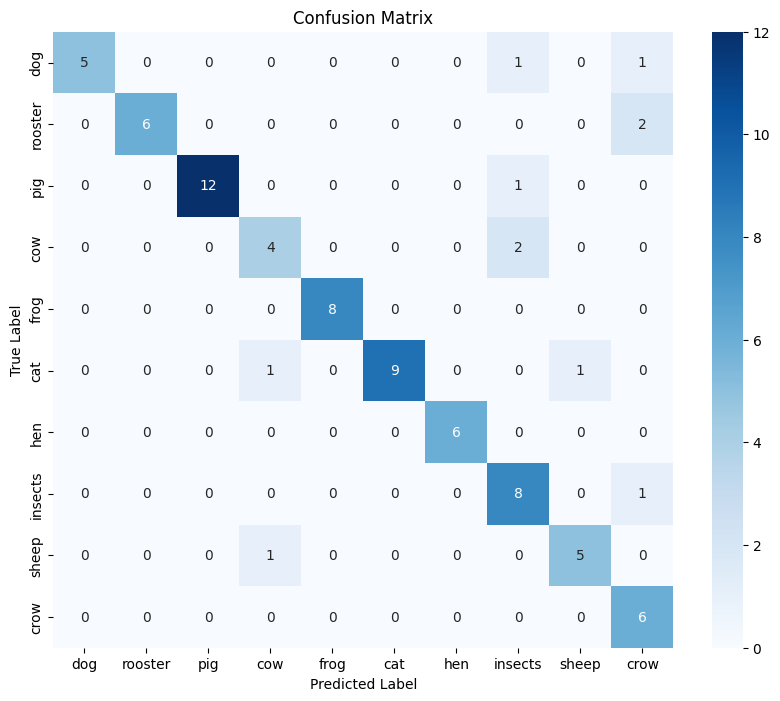

In [ ]:
# confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=animals, yticklabels=animals)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=animals))

Classification Report:

              precision    recall  f1-score   support

         dog       1.00      0.71      0.83         7
     rooster       1.00      0.75      0.86         8
         pig       1.00      0.92      0.96        13
         cow       0.67      0.67      0.67         6
        frog       1.00      1.00      1.00         8
         cat       1.00      0.82      0.90        11
         hen       1.00      1.00      1.00         6
     insects       0.67      0.89      0.76         9
       sheep       0.83      0.83      0.83         6
        crow       0.60      1.00      0.75         6

    accuracy                           0.86        80
   macro avg       0.88      0.86      0.86        80
weighted avg       0.89      0.86      0.87        80



# One Function

In [ ]:
# one function to preprocess and predict

def full_vggish(filename):
    # preprocess the .wav file
    esc_waveform = preprocess_wav('audio/' + filename)

    # run VGGish and get the embedding
    embedding = vgg_model(esc_waveform)
    embedding = np.expand_dims(embedding, axis=0)

    # use the full classification model
    predictions =  model.predict(embedding)

    # Get the predicted class label
    predicted_label_index = np.argmax(predictions[0])
    predicted_label = lb.classes_[predicted_label_index]

    print(f"Predicted Category: {predicted_label}")

In [ ]:
# test_int = 0
# full_vggish(esc50_animals.iloc[test_int]['filename'])
# print(f"True Category: {esc50_animals.iloc[test_int]['category']}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Predicted Category: dog
True Category: dog
